In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
from sklearn.metrics import r2_score
from sklearn.linear_model import SGDRegressor as sgd

In [30]:
class LogisticRegression:
    
    # The constructor for Logistic Regression
    def __init__ ( self,shape, loss = 'mse', lr = 0.001, iters = 1000,initialization = None ):
        
        # The list to hold the exponential value of w*x, for further easy calculating gradient
        self.exponentialList = []
         # The list to hold the sigmoid value of w*x, for further easy calculating gradient
        self.sigmoidList = []
        # The list to hold the predicted value
        self.predictionList = []
        self.predictionValList = []
        self.sigmoidValList = []
        self.exponentialValList = []
        # Initialization of w vector
        self.w = initialization
        # The learning rate, default is 0.0001
        self.lr = lr
        # The iterations, default is 1000
        self.iters = iters
        
        '''
        The loss function for prediction, default setting is mean square error,
        or another choice is binary cross entropy.
        The loss function for mean squared error is :
            loss = (y_actual - y_pred)**2 
            y_pred = total_reads * probability
            y_actual = methylated_counts
        
        The loss function for binary cross entropy is :
            loss = -(methylated_counts * np.log(probability) + unmethylated_counts*np.log(1-probability))
            Methylated_counts and unmethylated_counts are read from outside file.
        '''
        if loss != 'mse' and loss != 'binary_crossentropy':
            raise ValueError("Incorrect Loss Function. Argument should be mse or binary_crossentropy")
        self.loss = loss
        
    # The sigmoid Funtion implementation
    # During the calculation, we would store the result for future reference
    def sigmoid(self,data,train):

        if train:
            # If the dimension does not match
            if len(self.exponentialList) != data.shape[0]:
                self.exponentialList = [0]*data.shape[0]
                self.sigmoidList = [0]*data.shape[0]
                self.predictionList = [0]*data.shape[0] 

            for i,d in enumerate(data):
                exponential = np.exp(-np.matmul(d,self.w))
                sigmoid = 1/(1+exponential)
            
                # Store the value for future calculating the gradients
                self.exponentialList[i] = exponential
                self.sigmoidList[i] = sigmoid
        else:
            # If the dimension does not match
            if len(self.exponentialValList) != data.shape[0]:
                self.exponentialValList = [0]*data.shape[0]
                self.sigmoidValList = [0]*data.shape[0]
                self.predictionValList = [0]*data.shape[0] 
            for i,d in enumerate(data):
                exponential = np.exp(-np.matmul(d,self.w))
                sigmoid = 1/(1+exponential)
            
                # Store the value for future calculating the gradients
                self.exponentialValList[i] = exponential
                self.sigmoidValList[i] = sigmoid
    
    # Prediction function for Logistic Regression
    def predict (self,data, reads,train):
        # Calculate the sigmoid function for each DNA sequence
        self.sigmoid(data,train)
        for i in range(len(data)):
            if train:
                # Calculate the expected value for this binomial distribution
                self.predictionList[i] = reads[i] * self.sigmoidList[i]
            else:
                self.predictionValList[i] = reads[i] * self.sigmoidValList[i]
    
    # Gradient Calculation during training
    def gradient(self,data, reads, methy):
        
        '''
        data: kmers counts
        reads: total reads for one DNA sequence
        methy: methylated counts for that DNA sequence
        '''
        
        #Initialize the gradient
        gradient = np.zeros(self.w.shape)
        
        if self.loss == 'mse':
            
            for i,d in enumerate(data):
                gradient += 2*(methy[i]-reads[i] * self.sigmoidList[i])*(-1)*reads[i]*\
                (self.sigmoidList[i]**2)*self.exponentialList[i]*d
            #Take the normalization of gradient
            gradient = gradient/sum(reads)
            return gradient
        # If the loss function is binomial crossentropy
        else:
            for i,d in enumerate(data):
                gradient += reads[i]*self.sigmoidList[i]*self.exponentialList[i]*(-1)*d + \
                (reads[i] - methy[i])*d
            #Take the normalization of gradient
            gradient = gradient/sum(reads)
            return gradient
        
    # The loss function calculation   
    def lossCal (self, data, reads, methy,train=True):
        # predict the data and then store the results
        self.predict(data,reads,train)
        
        loss = 0
        if self.loss == 'mse':
            for i in range(len(data)):
                loss += (self.predictionList[i] - methy[i])**2
            return loss/len(data)
        else:
            for i in range(len(data)):
                loss += -(methy[i]*np.log(self.sigmoidList[i]) + (reads[i] - methy[i])*np.log(1-self.sigmoidList[i]))
            return loss/len(data)
        
    def fit(self,data, reads, methy,test_data,test_reads,test_methy):
        #initialize lists for storing variable
        self.exponentialList = [0]*data.shape[0]
        self.sigmoidList = [0]*data.shape[0]
        self.predictionList = [0]*data.shape[0] 
        
        currLoss = [self.lossCal(data,reads,methy)]
        valLoss = [self.lossCal(test_data,test_reads,test_methy,train=False)]
        for i in range(self.iters):
            # calculate gradient
            step = self.gradient(data,reads,methy)
            self.w -= self.lr * step
            # Rerun Logistic Regression, calculate the loss, update the lists to store the data
            newLoss = self.lossCal(data,reads,methy)
            newValLoss = self.lossCal(test_data,test_reads,test_methy,train=False)
            if abs(newLoss - currLoss[-1]) < 0.00001:
                print("The iterator stops at ", i, " steps")
                break
            currLoss.append(newLoss)
            valLoss.append(newValLoss)
            if i % 20 == 0:
                print("Training epoch: ", i)
                print("\tTraining Loss: ",newLoss)
                print('\tValidation Loss: ',newValLoss)
        return currLoss,valLoss

In [4]:
train_data = pd.read_csv('../CNN_Keras/SimulationCNN/Kmers6_counts_600bp.csv')
train_reads = pd.read_csv('../data/Mouse_DMRs_counts_total.csv',header = None)
train_methys = pd.read_csv('../data/Mouse_DMRs_counts_methylated.csv',header = None)
train_methy_level = pd.read_csv('../data/Mouse_DMRs_methylation_level.csv',header = None)
cell_type = 5
data = train_data.as_matrix()
level = train_methy_level.as_matrix()[:,cell_type]
reads = train_reads.as_matrix()[:,cell_type]
methy = train_methys.as_matrix()[:,cell_type]
print(data.shape,level.shape,reads.shape,methy.shape)
data_train = data[:48000]
level_train = level[:48000]
reads_train = reads[:48000]
methy_train = methy[:48000]
data_test = data[48000:]
level_test = level[48000:]
reads_test = reads[48000:]
methy_test = methy[48000:]

(58959, 2080) (58959,) (58959,) (58959,)


In [32]:
clf = sgd(loss = 'squared_loss',penalty = 'l1',n_iter=200)
clf.fit(data_train,level_train)

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=200, penalty='l1', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False)

In [33]:
clf.score(data_train,level_train)

0.2648154729228096

In [34]:
lr = LogisticRegression(train_data.shape,lr=0.005,loss = 'binary_crossentropy',iters = 500,initialization = clf.coef_)

In [35]:
train_loss, val_loss = lr.fit(data_train,reads_train,methy_train,data_test,reads_test,methy_test)

Training epoch:  0
	Training Loss:  53.991161265743415
	Validation Loss:  55.3310142646287
Training epoch:  20
	Training Loss:  47.429377663558064
	Validation Loss:  48.649384784005704
Training epoch:  40
	Training Loss:  47.06048124511136
	Validation Loss:  48.32848971014192
Training epoch:  60
	Training Loss:  46.969776743882335
	Validation Loss:  48.31806684709823
Training epoch:  80
	Training Loss:  46.8987526583388
	Validation Loss:  48.33113332338361
Training epoch:  100
	Training Loss:  46.83343113462243
	Validation Loss:  48.34816707285665
Training epoch:  120
	Training Loss:  46.772476630601176
	Validation Loss:  48.366920779677805
Training epoch:  140
	Training Loss:  46.71532931701174
	Validation Loss:  48.386816088836014
Training epoch:  160
	Training Loss:  46.661548391831964
	Validation Loss:  48.40755041869552
Training epoch:  180
	Training Loss:  46.61076313748873
	Validation Loss:  48.42890807191841
Training epoch:  200
	Training Loss:  46.562659366126276
	Validation L

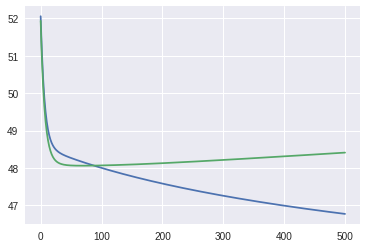

In [8]:
# plot
plt.plot(train_loss)
plt.plot(val_loss)
plt.show()

In [9]:
r2_score(lr.sigmoidValList, level_test)
r2_score(lr.sigmoidList,level_train)

-20.82898666904892